<a href="https://colab.research.google.com/github/Jadrianp29/testreko/blob/main/DS_C6_SC1_JesusAdrianAguilarPerez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introducción:

Ahora que ya conoces diferentes técnicas estadísticas y de visualización para tomar decisiones que te ayudan a mejorar el desempeño de tus modelos de máquinas inteligentes, deberás ayudar a Belén y a Juan a producir una máquina inteligente para ayudar al consorcio de hoteles a contar con un plan para reducir las cancelaciones de reservaciones. Recuerda que el objetivo es que Juan pueda entregar una máquina inteligente que pueda estimar las probabilidades de cancelación, así como separar a los clientes que van a cancelar de los que no. Estos resultados servirán a Belén para formular las estrategias para retener a los clientes y promocionar el destino, por lo que es necesario que ayudes a Juan a obtener un modelo con el menor error de clasificación posible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from yellowbrick.classifier.threshold import DiscriminationThreshold
from yellowbrick.classifier import (
    ConfusionMatrix, ClassPredictionError, ClassificationReport,
    PrecisionRecallCurve, ROCAUC, ClassPredictionError
)
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import roc_auc_score

# semilla para garantizar la reproducibildiad del código
seed = 20210610

In [2]:
Hotels=pd.read_csv('hotels.csv')

Analisis exploratorio

In [3]:
Hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
Hotels.isnull().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [5]:
Hotels['is_canceled'].nunique()

2

In [6]:
Hotels['is_canceled'] = Hotels['is_canceled'].astype('category')

In [7]:
Hotels.rename(columns={'is_canceled': 'y'}, inplace=True)


In [8]:
y = Hotels.y

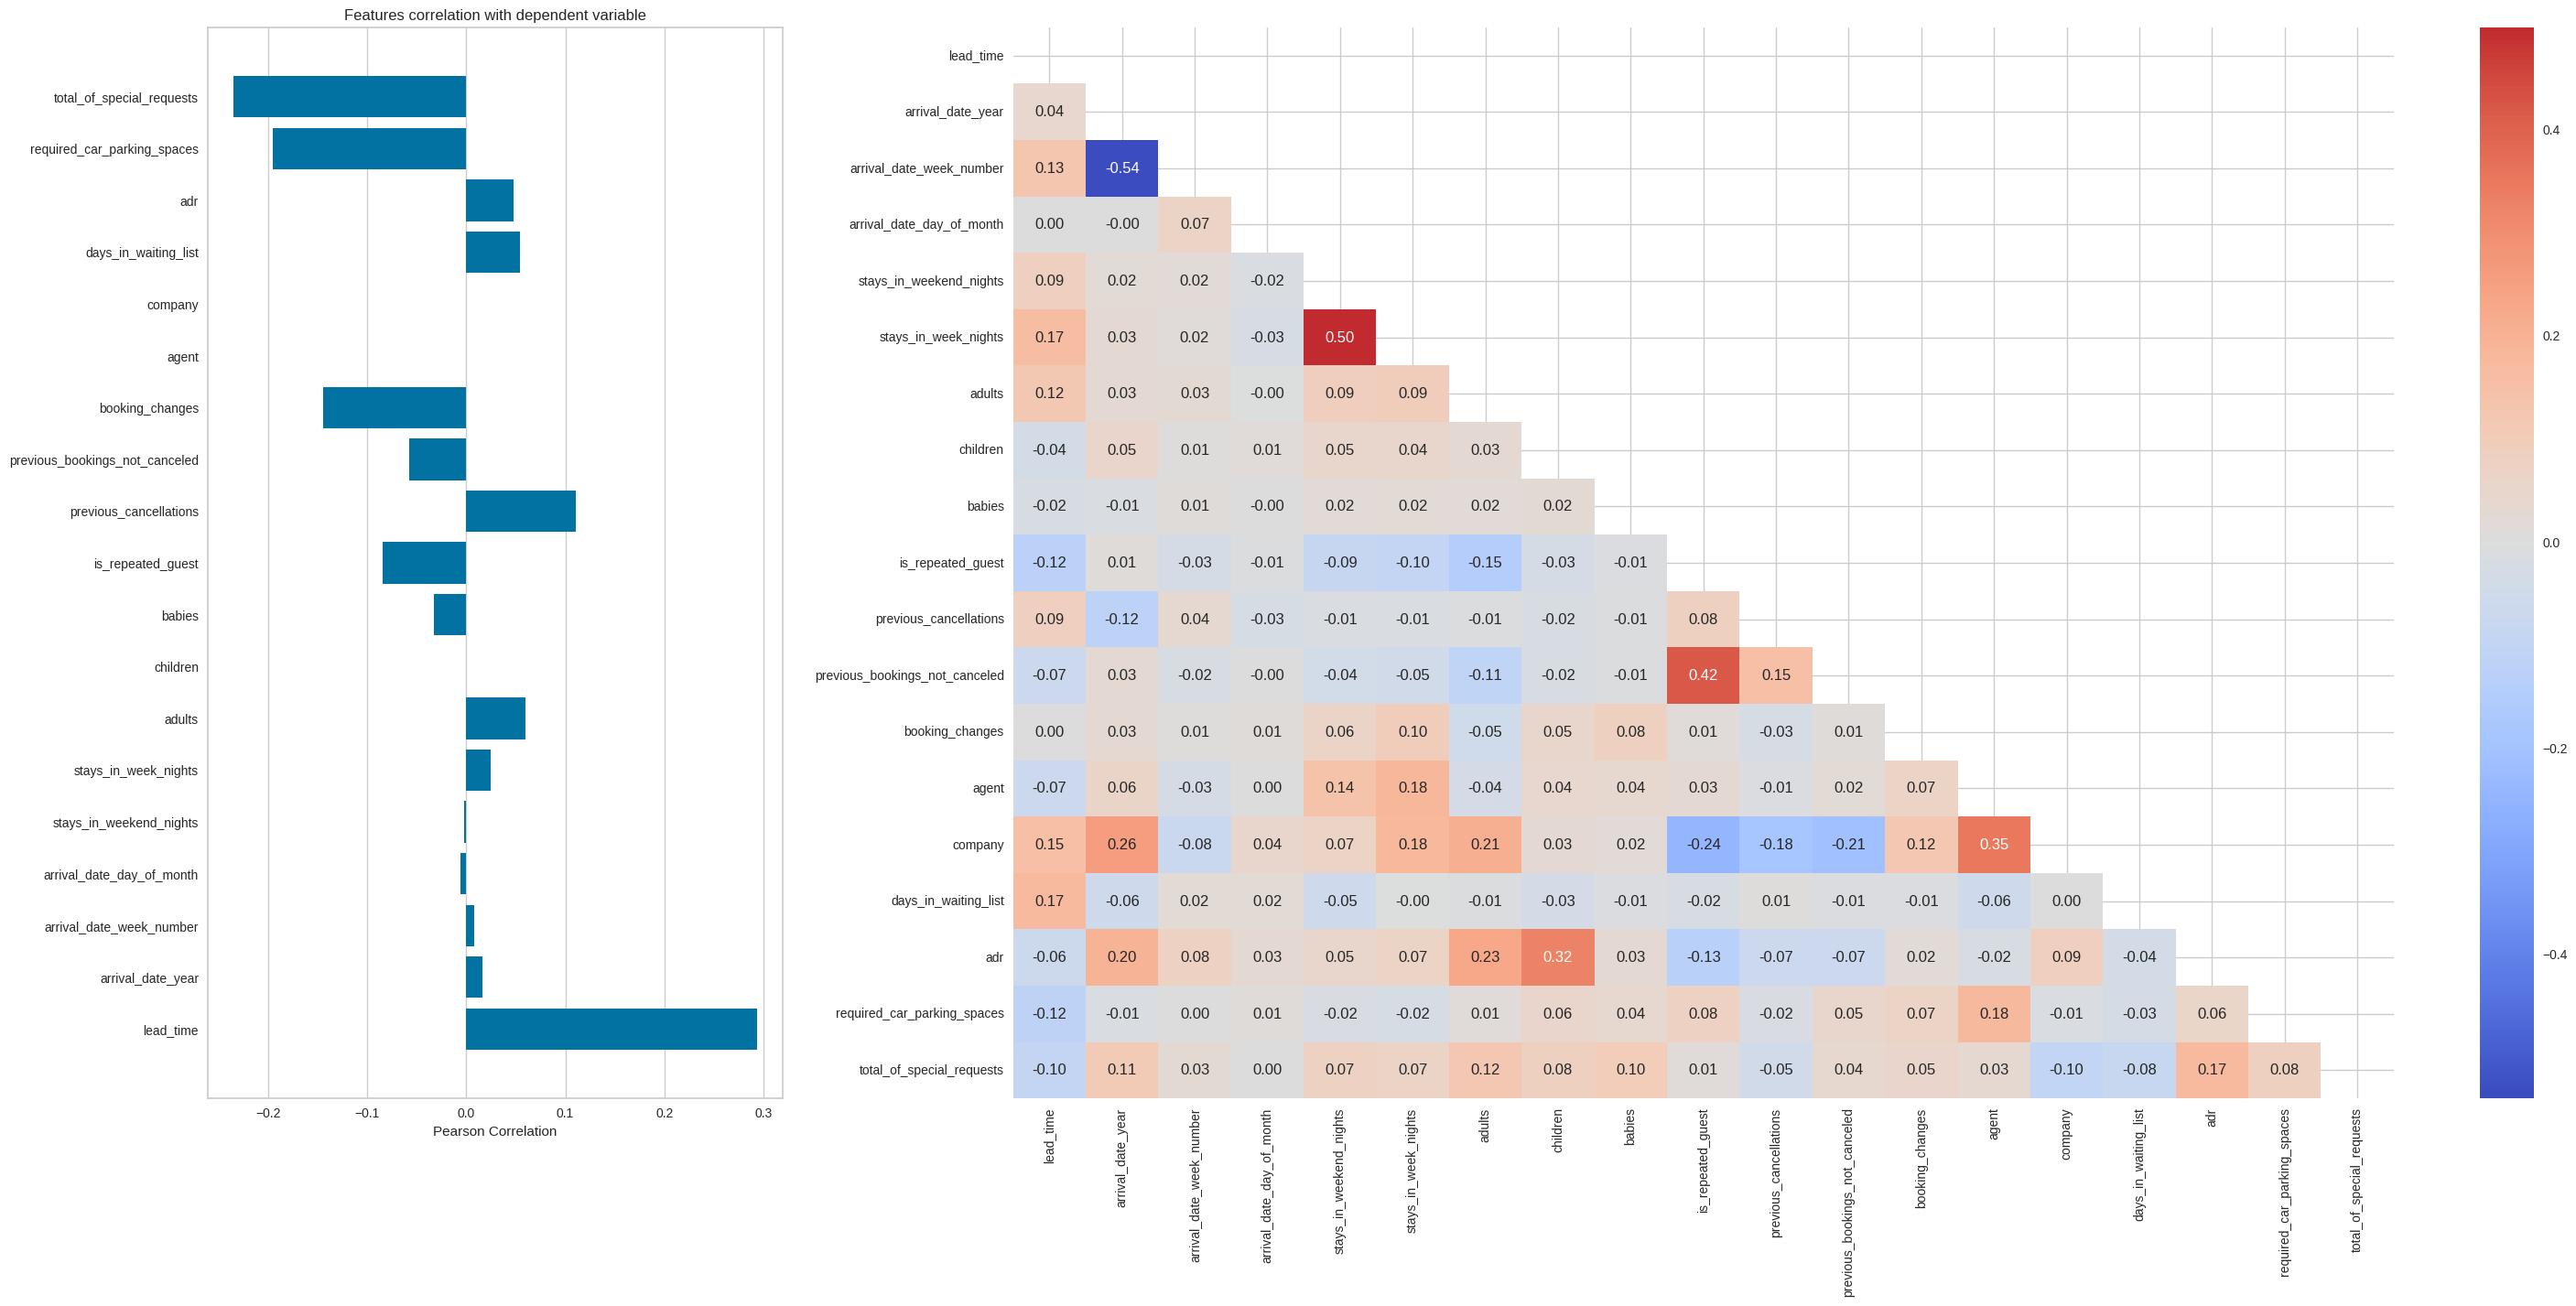

In [9]:
from yellowbrick.target import FeatureCorrelation
# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35.68, 15.20), gridspec_kw={'width_ratios': [1, 3]})


features = Hotels.select_dtypes(include=[np.number]).drop(columns=['y'], errors='ignore')

# Visualización con Yellowbrick
visualizer = FeatureCorrelation(ax=ax1, labels=features.columns)
visualizer.fit(features, Hotels['y'])
visualizer.finalize()

# Matriz de correlación
corr = features.corr()


mask = np.triu(np.ones_like(corr, dtype=bool))


sns.heatmap(corr, mask=mask, center=0, ax=ax2, annot=True, fmt=".2f", cmap="coolwarm")


plt.show()

Se eliminan las variables arrival_date_week_number
arrival_date_day_of_month
stays_in_week_nights
adults su correlación es casi 0

In [10]:
Hotels['agent'].nunique()

333

In [11]:
Hotels.drop(['company'], axis=1, inplace=True),
Hotels[['children', 'country', 'agent']] = Hotels[['children', 'country', 'agent']].fillna('Desconocido')

In [12]:
Hotels.drop(['arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_week_nights', 'adults'], axis=1, inplace=True)

In [13]:
Hotels.describe()

,lead_time,arrival_date_year,stays_in_weekend_nights,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,104.011416,2016.156554,0.927599,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,106.863097,0.707476,0.998613,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,18.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,69.000000,2016.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,160.000000,2017.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,737.000000,2017.000000,19.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


Detectar si hay un problema de desbalance en los datos y a partir de aquí actuar acorde al resultado:

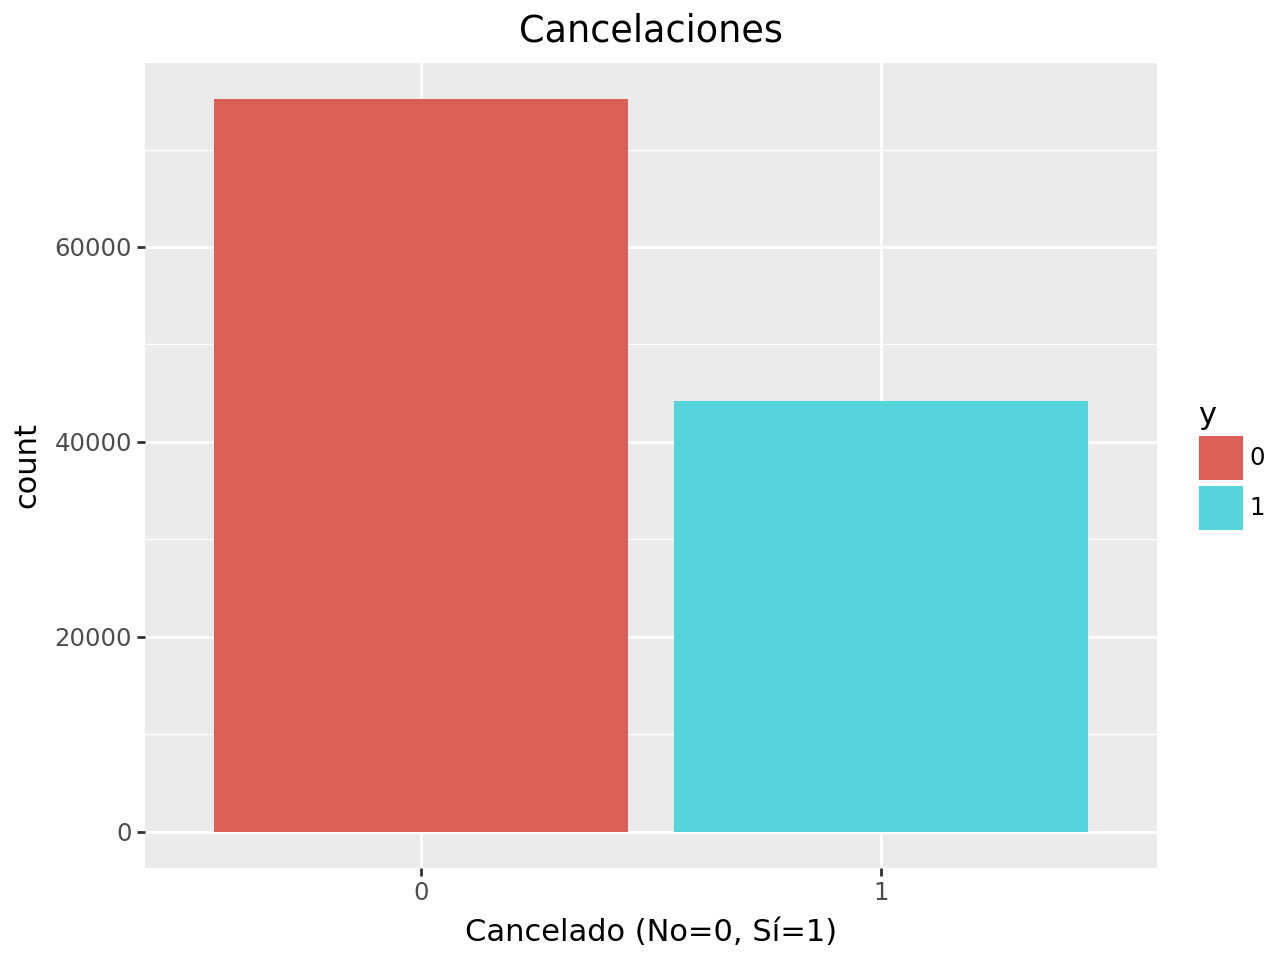

In [14]:
(
    ggplot(Hotels.assign(count = 1), aes( x = 'y', y = 'count',fill = 'y')) +
    geom_col() +
    labs(title = "Cancelaciones",
         x="Cancelado (No=0, Sí=1)"
         )
)

Las clases estan medianamente balanceadas.

Construir un conjunto de entrenamiento y prueba.

In [15]:
from sklearn.model_selection import train_test_split
train_set, temp_set = train_test_split(
    Hotels,
    test_size=0.5,
    stratify=Hotels.y,
    random_state=42
)
validation_set, test_set = train_test_split(
    temp_set,
    test_size=0.5,
    stratify=temp_set.y,
    random_state=42
)

In [16]:
train_set.shape, validation_set.shape, test_set.shape

((59695, 27), (29847, 27), (29848, 27))

In [17]:
train_set.y.value_counts(normalize=True)

,proportion
y,
0,0.629584
1,0.370416


In [18]:
validation_set.y.value_counts(normalize=True)

,proportion
y,
0,0.629578
1,0.370422


In [19]:
test_set.y.value_counts(normalize=True)

,proportion
y,
0,0.62959
1,0.37041


In [20]:
train_set.columns

Index(['hotel', 'y', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'stays_in_weekend_nights', 'children', 'babies', 'meal', 'country',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [21]:
test_set.columns

Index(['hotel', 'y', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'stays_in_weekend_nights', 'children', 'babies', 'meal', 'country',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

Seleccionar caracteristicas

In [22]:
def fun_preprocess_numeric_variables(df):
    df_numeric = df[['lead_time', 'arrival_date_year','stays_in_weekend_nights', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes','days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']]
    df_numeric.loc[:, 'children'] = pd.to_numeric(df_numeric['children'], errors='coerce').fillna(-1)

    return df_numeric

def fun_preprocess_categorical_variables(df):
    categorical_cols = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type','customer_type',]
    df_categorical = pd.get_dummies(df[categorical_cols], drop_first=True)
    return df_categorical
def fun_preprocesar_atributos(df):
    df_numeric = fun_preprocess_numeric_variables(df)
    df_categorical = fun_preprocess_categorical_variables(df)

    return pd.concat([df_numeric, df_categorical], axis = 1)
def fun_preprocesar_categoria(df):

    return pd.get_dummies(df.y, drop_first=True).astype('int64').values.ravel()


Estas líneas nos sirven para validar que las columnas de los tres conjuntos de datos después de aplicar el preprocesamiento están correctas.

In [23]:
train_processed = fun_preprocesar_atributos(train_set)
test_processed = fun_preprocesar_atributos(test_set).reindex(columns=train_processed.columns, fill_value=0)
validation_processed = fun_preprocesar_atributos(validation_set).reindex(columns=train_processed.columns, fill_value=0)



In [24]:
assert train_processed.columns.tolist() == test_processed.columns.tolist()
assert train_processed.columns.tolist() == validation_processed.columns.tolist()

In [25]:
X_train = fun_preprocesar_atributos(train_set)
y_train = fun_preprocesar_categoria(train_set)

X_val = fun_preprocesar_atributos(validation_set).reindex(columns=X_train.columns, fill_value=0)
y_val = fun_preprocesar_categoria(validation_set)

X_test = fun_preprocesar_atributos(test_set)
y_test = fun_preprocesar_categoria(test_set)

In [26]:
X_train.head()

,lead_time,arrival_date_year,stays_in_weekend_nights,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
109070,91,2017,2,0.0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
111648,16,2017,0,0.0,0,0,0,0,2,0,...,False,False,False,False,False,False,False,False,True,False
85625,16,2016,0,0.0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,True
53341,156,2016,1,0.0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,True,False
64455,11,2017,0,0.0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [27]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((59695, 205), (29847, 205), (29848, 186), (59695,), (29847,), (29848,))

Reportar el error de clasificación el conjunto de prueba con un modelo base. Utilizando el conjunto de prueba:
Reporta el error de clasificación F1.
Grafica e interpreta la matriz de confusión.
Grafica e interpreta reporte de clasificación de precisión, recall y F1 score.
Grafica e interpreta la curva ROC y el AUC score.

In [28]:
fun_preprocesar_atributos(train_set).shape, fun_preprocesar_atributos(validation_set).shape, fun_preprocesar_atributos(test_set).shape

((59695, 205), (29847, 193), (29848, 186))

In [29]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(
    max_depth = 2,
    class_weight = 'balanced',
    random_state=seed
)

clf_dt.fit(X_train, y_train)
y_pred = clf_dt.predict(X_val)

In [30]:
def fun_graficar_matriz_confusion(model, X_val_test, y_val_test):
    # Obtener predicciones
    y_pred = model.predict(X_val_test)

    # Calcular matriz de confusión
    cm = confusion_matrix(y_val_test, y_pred)

    # Graficar con Seaborn
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

    plt.xlabel("Predicciones")
    plt.ylabel("Valores Reales")
    plt.title("Matriz de Confusión")
    plt.show()

In [31]:
def fun_graficar_reporte_clasificacion(model, X_val_test, y_val_test):

    fig, ax = plt.subplots(figsize = (6,5))
    visualizer = ClassificationReport(
        model,
        classes=['no', 'yes']
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_val_test, y_val_test)
    visualizer.show();
def fun_graficar_curva_roc(model, X_val_test, y_val_test):

    fig, ax = plt.subplots(figsize = (6,6))
    roc_curves_visualizer = ROCAUC(
        model,
        classes=['no', 'yes']
    )
    roc_curves_visualizer.fit(X_train, y_train)
    roc_curves_visualizer.score(X_val, y_val)
    roc_curves_visualizer.show();

def fun_imprimir_roc_auc_score(model, X_val_test, y_val_test):

    print(
        "roc_auc_score: {}".format(
            np.round(roc_auc_score(y_val_test, model.predict_proba(X_val_test)[:,1]), 3)
        )
    )

def fun_graficar_error_clasificacion(model, X_val_test, y_val_test):

    fig, ax = plt.subplots(figsize = (7,6))
    cpe_viz = ClassPredictionError(model, classes = ['no', 'yes'])
    cpe_viz.fit(X_train, y_train)
    cpe_viz.score(X_val_test, y_val_test)
    cpe_viz.show();

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


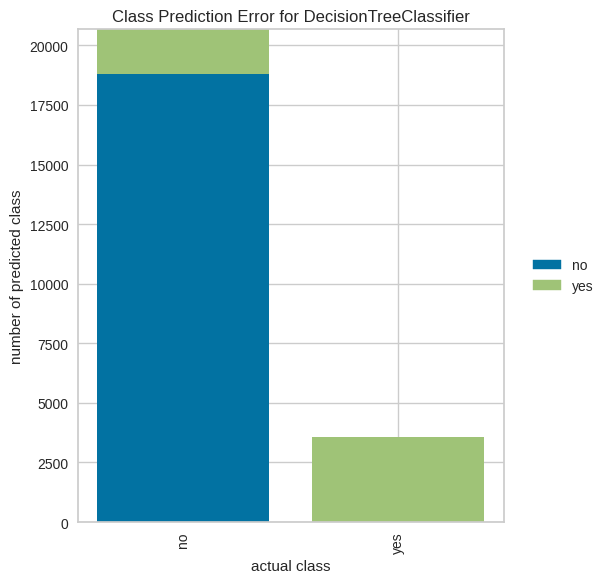

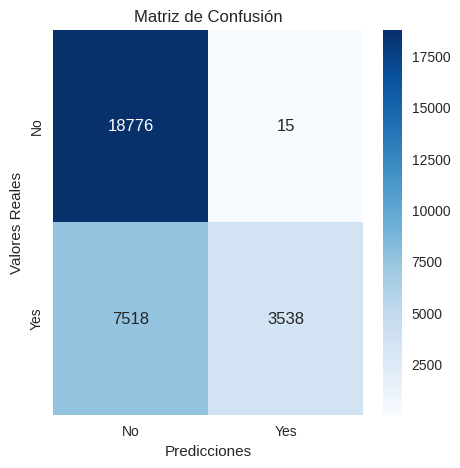

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


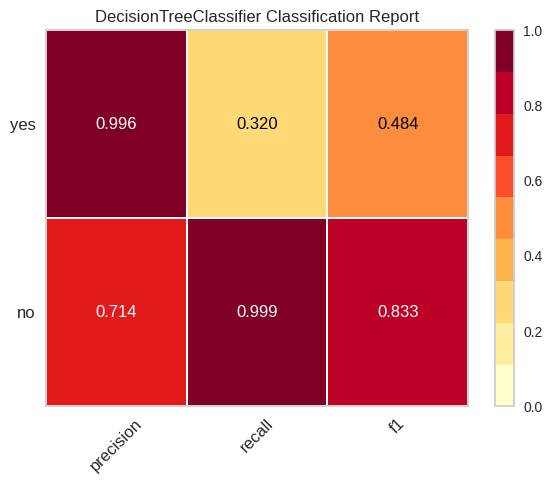

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


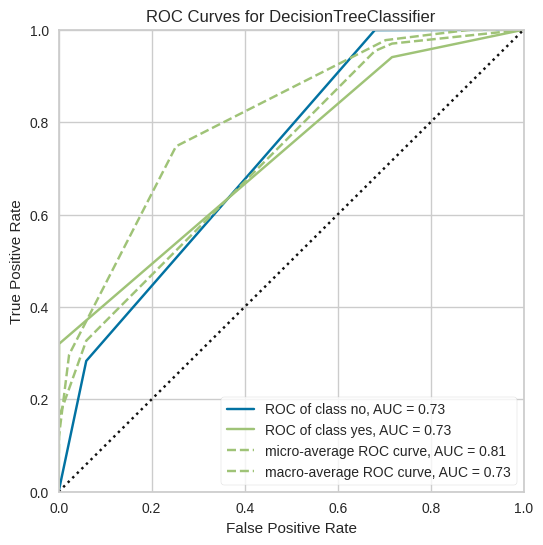

In [32]:
fun_graficar_error_clasificacion(clf_dt, X_val, y_val),
fun_graficar_matriz_confusion(clf_dt, X_val, y_val),
fun_graficar_reporte_clasificacion(clf_dt, X_val, y_val),
fun_graficar_curva_roc(clf_dt, X_val, y_val)

Producir un modelo que supere el mejor F1-score de tu modelo base en el conjunto de
prueba. Considera las siguientes estrategias vistas en el modulo

In [33]:
from sklearn.model_selection import GridSearchCV
# Especificamos un modelo de árbol de decisión
clf_dt = DecisionTreeClassifier(
    class_weight = 'balanced', 	# Indicamos que se deben reponderar las clases.
    random_state=seed			# Indicamos una semilla para reproducibilidad.
)

# Especificar diccionario de parametros y valores a explorar
params = {
    'max_depth':[5, 10, 50, 100, 150, 200],
    'min_samples_split':[2, 4, 6, 8],
    'min_samples_leaf':[1, 2, 4, 5]
}
# Especificar opciones del Grid Search
grid_search = GridSearchCV(
    clf_dt, 				# Indicar el modelo (debe ser un estimador).
    scoring = 'roc_auc', 	# Indicar la métrica para evaluar el desempeño del
    						# modelo en validación cruzada.
    param_grid=params, 		# Indicar el diccionario de parámetros y valores
    cv = 5, 				# Indicar los k cortes de validación cruzada.
    return_train_score=True,# Agregar el error de entrenamiento
    n_jobs = -1				# Indicar cuántos CPUs utilizar para paralelizar el
    						# trabajo.

)
# Entrenar los modelos
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=20210610),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 50, 100, 150, 200],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 4, 6, 8]},
             return_train_score=True, scoring='roc_auc')

In [34]:
def fun_plot_grid_search_results(df):
    # Elegir paleta divergente de colores
    cm = sns.diverging_palette(5, 250, as_cmap=True)

    return (
        pd.concat([

            df['params'].apply(pd.Series),
            df[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
            axis = 1
        )

        .sort_values(by = 'rank_test_score')
        # Pintar el fondo de la celda a partir del error de validación
        .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
    )

In [35]:
def fun_resumen_grid_search(grid_search):

    best_params = grid_search.best_params_
    print("\nSe evaluaron {} modelos utilizando el grid search.".format(pd.DataFrame(grid_search.cv_results_).shape[0]))
    print("\nLos hiperparámetros del mejor modelo son: " + str(best_params) + "\n")

In [36]:
df_best_params = pd.DataFrame(grid_search.cv_results_)
tabla_resultados = fun_plot_grid_search_results(df_best_params)
tabla_resultados

,max_depth,min_samples_leaf,min_samples_split,mean_train_score,mean_test_score,rank_test_score
31,10,5,8,0.921592,0.915092,1
30,10,5,6,0.921592,0.915092,1
29,10,5,4,0.921592,0.915092,1
28,10,5,2,0.921592,0.915092,1
27,10,4,8,0.921755,0.915051,5
26,10,4,6,0.921755,0.915051,5
25,10,4,4,0.921755,0.915051,5
24,10,4,2,0.921755,0.915051,5
23,10,2,8,0.921967,0.914631,9
22,10,2,6,0.922044,0.914620,10


In [37]:
fun_resumen_grid_search(grid_search)


Se evaluaron 96 modelos utilizando el grid search.

Los hiperparámetros del mejor modelo son: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}



In [38]:
clf2_dt = DecisionTreeClassifier(
    max_depth = 10,
    min_samples_leaf = 5,
    min_samples_split = 2,
    class_weight = 'balanced',
    random_state=seed
)

clf2_dt.fit(X_train, y_train)
y_pred = clf2_dt.predict(X_val)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


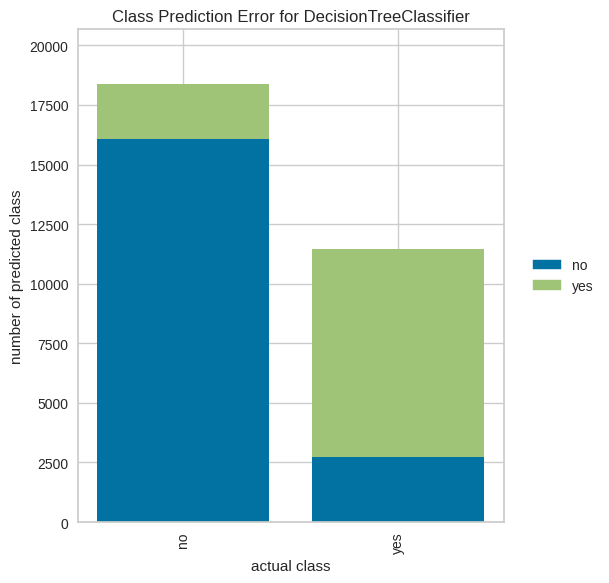

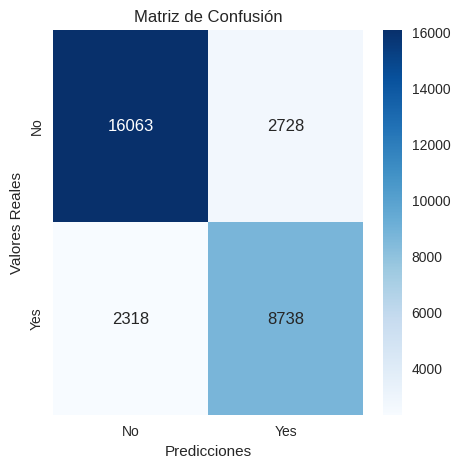

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


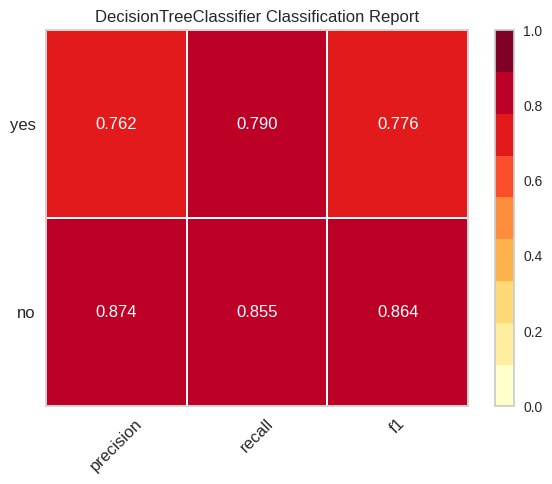

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


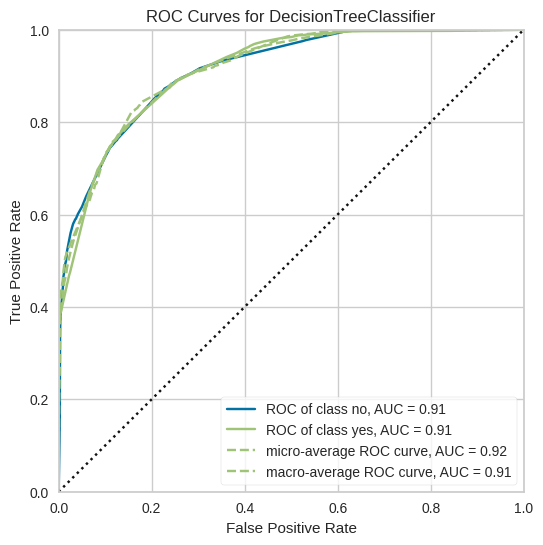

In [39]:
fun_graficar_error_clasificacion(clf2_dt, X_val, y_val),
fun_graficar_matriz_confusion(clf2_dt, X_val, y_val),
fun_graficar_reporte_clasificacion(clf2_dt, X_val, y_val),
fun_graficar_curva_roc(clf2_dt, X_val, y_val)

In [40]:
best_model = grid_search.best_estimator_

 Genera un CSV con todos los datos de reservaciones que incluya solo tres columnas el id
de la reservación, la probabilidad de cancelación y la clasificación de cancelación (0 ó
1), que Juan le va a entregar a Belén.

In [41]:
# Utilizar el mejor modelo para predecir la clase
y_pred = best_model.predict(X_val)
# Mostrar las clases de los primeros 20 clientes
y_pred[:20]

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0])

In [44]:
# Crea un DataFrame con las columnas requeridas
results_df = pd.DataFrame({
    'reservation_id': range(len(X_test)), # Crea una columna con un ID de reservación
    'probability_of_cancellation': best_model.predict_proba(test_processed)[:, 1],
    'is_canceled': best_model.predict(test_processed)
})

# Guarda el DataFrame en un archivo CSV
results_df.to_csv('cancellation_predictions.csv', index=False)

1)Eliminando los resultados cercanos a 0 que indico la matriz de correlacion 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_week_nights', 'adults'.
2)Realizando un grid search con un arbol de desicion y obteniendo los nuevos hiperparametros , podemos mejorar nuestro F1 score y tener un ROC de .91 por lo que se mejora el modelo.
3) El modelo presenta un F1 score de 0.776 lo que es un buen puntaje pero aun se puede mejorar.
4) EL Roc tiene un valor de 0.91 l ocual indica que el modelo es muy objetivo para predecir.
5) En el modelo de negocio es un buen estimado que ayudara a predecir si un cliente cancelara una reservacion.